## Library Imports

In [5]:
import numpy as np
import pandas as pd
import os
from os import path
import math
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix

import pickle

import cv2
import math
from tqdm import tqdm

from PIL import Image
import os
import copy
from imagecorruptions import corrupt

In [2]:
os.chdir("..")

In [3]:

from DistanceMetricsVec import Anderson_Darling_Dist_PVal as AD_p
from DistanceMetricsVec import Kolmogorov_Smirnov_Dist_PVal as KS_p


In [ ]:
from utils.CriticalValues import KS_crit, AD_crit

## Import Data

In [6]:
# Reading the input images and putting them into a numpy array
data=[]
labels=[]

height = 32 #import as 32x32 minimum size required by corrpution
width = 32
channels = 3

n_inputs = height * width*channels

ClassFolders = os.listdir("Final_Training/Images")
classes = len(ClassFolders)

for idx, fileName in enumerate(ClassFolders) :
    path = os.path.join("Final_Training/Images", fileName)
    #path = "C:/cmder/Python_Tests/GTSRB/Train/{0}/".format(i)
    print(path)
    classImges = os.listdir(path)
    for img in classImges:
        try:
            image=cv2.imread(os.path.join(path, img))
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            data.append(np.array(size_image))
            labels.append(idx)
        except AttributeError:
            print(os.path.join(path, img) + " is not an image")
            
Cells=np.array(data)
labels=np.array(labels)

#Randomize the order of the input images
s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

Final_Training/Images\00001
Final_Training/Images\00001\GT-00001.csv is not an image
Final_Training/Images\00002
Final_Training/Images\00002\GT-00002.csv is not an image
Final_Training/Images\00003
Final_Training/Images\00003\GT-00003.csv is not an image
Final_Training/Images\00004
Final_Training/Images\00004\GT-00004.csv is not an image
Final_Training/Images\00005
Final_Training/Images\00005\GT-00005.csv is not an image
Final_Training/Images\00006
Final_Training/Images\00006\GT-00006.csv is not an image
Final_Training/Images\00007
Final_Training/Images\00007\GT-00007.csv is not an image
Final_Training/Images\00008
Final_Training/Images\00008\GT-00008.csv is not an image
Final_Training/Images\00009
Final_Training/Images\00009\GT-00009.csv is not an image
Final_Training/Images\00010
Final_Training/Images\00010\GT-00010.csv is not an image
Final_Training/Images\00011
Final_Training/Images\00011\GT-00011.csv is not an image
Final_Training/Images\00012
Final_Training/Images\00012\GT-00012.

## Processing and Corruption

In [8]:
X_train_init, X_val_init, y_train_init, y_val_init = train_test_split(Cells, labels, test_size=0.40, random_state=42, stratify=labels)
X_val_init, X_test_init, y_val_init, y_test_init = train_test_split(X_val_init, y_val_init, test_size=0.7, random_state=42, stratify=y_val_init)

In [9]:
X_train = X_train_init.astype('float32')/255 
X_val = X_val_init.astype('float32')/255
X_test = X_test_init.astype('float32')/255 #all will be normalized, but corrupted images will be overwritten

In [10]:
#select a random 50% fo the test data indecies to be corrupted
corruption_id = np.random.choice(X_test.shape[0], size = math.ceil(0.5 *X_test.shape[0]), replace=False)

# in percentages, 0-75 frost, 25-100 fog with 25-50 overlap
first_corruption = corruption_id[:math.ceil(0.75*len(corruption_id))]
second_corruption = corruption_id[math.ceil(0.25*len(corruption_id)):]

corr_type = ['frost', 'fog']
X_test_corrupted = copy.deepcopy(X_test) #copy to override

for batch in tqdm(corr_type):
    idx_list = first_corruption if batch == 0 else second_corruption
    for i in idx_list:
    
            
        image = X_test_init[i,:]
        image = (corrupt(np.array(image), corruption_name=batch, severity=5)).astype('float32')/255

        X_test_corrupted[i,:] = image.astype('float32')/255 #normalize
            

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.37s/it]


In [19]:
print(X_train.shape, X_test_corrupted.shape, X_val.shape)

(22555, 32, 32, 3) (10526, 32, 32, 3) (4511, 32, 32, 3)


In [20]:
#Flattening training and testing data 

X_train_f = X_train.flatten().reshape((22555, 32*32*3))
X_test_f = X_test_corrupted.flatten().reshape((10526, 32*32*3))

## Build Model

In [21]:
pipeSVM = Pipeline([('scaler', StandardScaler()),
                 ('SVM', SVC(C=10, gamma=0.001, kernel="rbf"))])

In [24]:
pipeSVM.fit(X_train_f, y_train_init)

Pipeline(steps=[('scaler', StandardScaler()), ('SVM', SVC(C=10, gamma=0.001))])

In [25]:
y_pred = pipeSVM.predict(X_test_f)

In [27]:
mask = np.zeros(len(y_pred))
for idx, yp in enumerate(y_pred):
    mask[idx] = yp == y_test_init[idx]
    
print(mask)

[0. 1. 1. ... 1. 1. 0.]


In [28]:
print(len(mask) - mask.sum() )

4281.0


## SafeML Implementation

In [35]:
def get_statistical_distance(train_set, test_set):
    #return statistical distance measures
    if (train_set.shape[1] != test_set.shape[1]):
        print(f"input features are not compatible. input one size {train_set.shape[1]} does not match input two size {test_set.shape[1]}")
        return None
    else:
        df_features = train_set.shape[1]
        
    df_features = train_set.shape[1]

    Anderson_Darling_distances = np.zeros(df_features)
    Kolmogorov_Smirnov_distances = np.zeros(df_features)

    ss_Anderson_Darling_distances = np.zeros(df_features)
    ss_Kolmogorov_Smirnov_distances = np.zeros(df_features)

    for i in range(df_features):

        pVal_ad, ad_res = AD_p(train_set[:, i], test_set[:, i])
        ss_Anderson_Darling_distances[i] = ad_res if (pVal_ad < 0.05) else np.nan
        #Anderson_Darling_distances[i] = ad_res
        
        pVal_ks, ks_res = KS_p(train_set[:, i], test_set[:, i])
        ss_Kolmogorov_Smirnov_distances[i] = ks_res if (pVal_ks < 0.05) else np.nan


    Anderson_Darling_distance = (np.nanmean(ss_Anderson_Darling_distances, dtype=np.float64),
                                 np.nanstd(ss_Anderson_Darling_distances, dtype=np.float64))
    Kolmogorov_Smirnov_distance = (np.nanmean(ss_Kolmogorov_Smirnov_distances, dtype=np.float64),
                                   np.nanstd(ss_Kolmogorov_Smirnov_distances, dtype=np.float64))

    
    return {
            'Anderson_Darling_dist': Anderson_Darling_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance
           }

In [32]:
train_samplespace = X_train_f
test_correct = X_test_f[mask == 1]
test_incorrect = X_test_f[mask ==0]

print(test_correct.shape, test_incorrect.shape)

(6245, 3072) (4281, 3072)


### Measure SDD using the flattened pixels

In [81]:
val_range = range(5, 101, 5)
crit_vals = np.zeros((2, len(val_range)))

correct_dist = np.zeros((2, len(val_range)))
incorrect_dist = np.zeros((2, len(val_range)))

for idx, smp_n in tqdm(enumerate(val_range)):
    
    crit_vals[0, idx] = AD_crit(0.1, smp_n, smp_n)
    crit_vals[1, idx] = KS_crit(0.1, smp_n, smp_n)
    
    
    idx_train = np.random.choice(train_samplespace.shape[0], smp_n, replace=False)
    idx_correct = np.random.choice(test_correct.shape[0], smp_n, replace=False)
    idx_incorrect = np.random.choice(test_incorrect.shape[0], smp_n, replace=False)

    correct = get_statistical_distance(train_samplespace[idx_train, :32*32], test_correct[idx_correct, :32*32])
    incorrect = get_statistical_distance(train_samplespace[idx_train, :32*32], np.concatenate((test_incorrect[idx_incorrect[:int(smp_n*0.32)], :32*32],
                                                                                            test_correct[idx_correct[int(smp_n*0.32):], :32*32])))
    
    for dist_idx, dist_name in enumerate(['Anderson_Darling_dist', 'Kolmogorov_Smirnov_dist']):
        correct_dist[dist_idx, idx] = correct[dist_name][0]
        incorrect_dist[dist_idx, idx] = incorrect[dist_name][0]


20it [59:45, 179.29s/it]


In [82]:
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

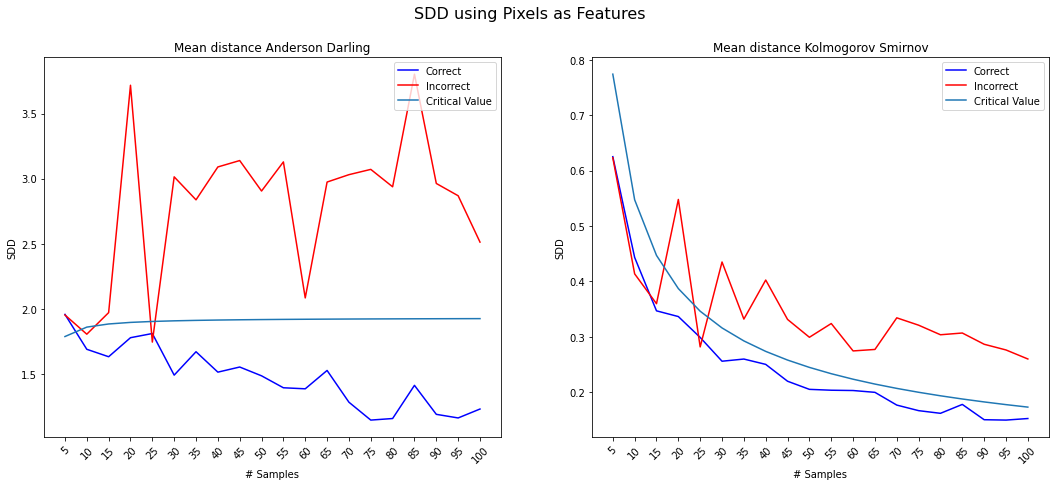

In [84]:
column_names=[
                "Anderson Darling",
                "Kolmogorov Smirnov",

            ]

fig=plt.figure(figsize=[18,7])
columns = 2
rows = 1
#for factor in range(15):
    #correct_meas, incorrect_meas = to_numpy(lst_correct_list[factor], lst_correct_list[factor])
fig.suptitle('SDD using Pixels as Features', fontsize=16)
for i in range(1, 3):
    plt.subplot(rows, columns, i)
    y1, y2 = correct_dist[i-1,:], incorrect_dist[i-1,:]
    #print(y1, y2)
    nans, x= nan_helper(y1)
    if (nans.sum()):
        y1[nans]= np.interp(x(nans), x(~nans), y1[~nans])

    plt.plot(y1, 'b')
    plt.plot(y2, 'r')
    plt.plot(crit_vals[i-1,:], )
    plt.xticks(range(20), range(5, 101, 5), rotation = 45)
    title_str = "Mean distance " + column_names[i-1]
    plt.title(title_str)
    plt.legend(["Correct", "Incorrect", "Critical Value"], loc = 1)
    plt.ylabel("SDD")
    plt.xlabel("# Samples")
plt.show()